# Labb 5

Johannes Hedström

In [ ]:
# Läser in paket
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras
import tensorflow.keras as keras
print('Keras version:',tensorflow.keras.__version__)

# Helper libraries
import os
import numpy as np
from numpy import argmax

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# For this Lab
import random
import gym



TensorFlow version: 2.12.0
Keras version: 2.12.0


In [ ]:
import sys
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
    !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-17a1018b-3459-9b6a-92a2-e000c70d3011)


Q-inlärning fungerar genom att studera en agent som "leker" och gradvis förbättrar skattningar av q-värden och när dessa q-värden skattningar närmar sig att vara precisa så är den optimala policyn att välja det högsta q-värdet(greedy).


In [ ]:
# Define some useful functions / Flytande/löpande medel
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [ ]:
# Inspired by RL researchers and written by Kalle Prorok for a Deep Learning Course
# Umeå Sweden 2019

# A set of parameters that is working well
EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 10     # discretization steps per state variable (aviod odd numbers), org val = 10

# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state

In [ ]:
# Create the Gym environment (CartPole)
if gym.__version__[:4] == '0.26':
    env = gym.make('CartPole-v1')
elif gym.__version__[:4] == '0.25':
    env = gym.make('CartPole-v1', new_step_api=True)
else:
    raise ImportError(f"Requires gym v25 or v26, actual version: {gym.__version__}")

observation = env.reset(seed=42) # seed it to something known

In [ ]:
average_cumulative_reward = 0.0

episode_reward = np.zeros(EPISODES)

print('Action space is:', env.action_space)
print('Observation space is:', env.observation_space)

# Q-table for the discretized states, and two actions
num_states = DISCRETE_STEPS ** 4
qtable = [[0., 0.] for state in range(num_states)]
print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

# Loop over episodes
# To make the training animated, look at Geron's code at
# https://colab.research.google.com/github/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb#scrollTo=AYBkxtFH307T
# or https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
for i in range(EPISODES):
    state4D = env.reset()
    state = make_state(state4D)

    terminate = False
    cumulative_reward = 0.0

    # Loop over time-steps
    while not terminate:
        # Compute what the greedy action for the current state is
        qvalues = qtable[state]
        greedy_action = argmax(qvalues)

        # Sometimes, the agent takes a random action, to explore the environment
        if random.random() < EPSILON:
            action = random.randrange(2)
        else:
            action = greedy_action

        # Perform the action
        next_state, reward, terminate, *_ = env.step(action)  # truncated & info is ignored
        next_state = make_state(next_state)

        # Update the Q-Table
        td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
        qtable[state][action] += LEARNING_RATE * td_error
        # Update statistics
        cumulative_reward += reward
        state = next_state

    # store reward for every episode
    episode_reward[i] = cumulative_reward

    # Adapt epsilon and learning rate here

    # Per-episode statistics
    if ((i % 500)==0):
      print(i, cumulative_reward, sep=',')

Action space is: Discrete(2)
Observation space is: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Q-table = 10000 x 2
0,10.0
500,30.0
1000,59.0
1500,70.0
2000,32.0
2500,28.0
3000,33.0
3500,38.0
4000,46.0
4500,59.0
5000,79.0
5500,45.0
6000,32.0
6500,45.0
7000,15.0
7500,38.0
8000,40.0
8500,29.0
9000,49.0
9500,35.0
10000,60.0
10500,38.0
11000,58.0
11500,46.0
12000,10.0
12500,38.0
13000,79.0
13500,27.0
14000,35.0
14500,64.0


Genom att titta på kumulativa medelvärdet för rewards ser vi att ingen är speciellt hög och att modellen inte är bra. Kolumn 1 visar episod och kolumn 2 den kumulativa rewarden.

 Vilka 4 mätvärden ingår i tillståndsinformationen som är grund för om man ska putta vagnen till höger eller vänster?

 De 4 mätvärden som är i grund för detta syns i printen ovan för Observation space vilket då är  [-4.8000002e+00, -3.4028235e+38 ,-4.1887903e-01, -3.4028235e+38] eller [4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38] vilket styr intervallen för de 4 mätvärdena.

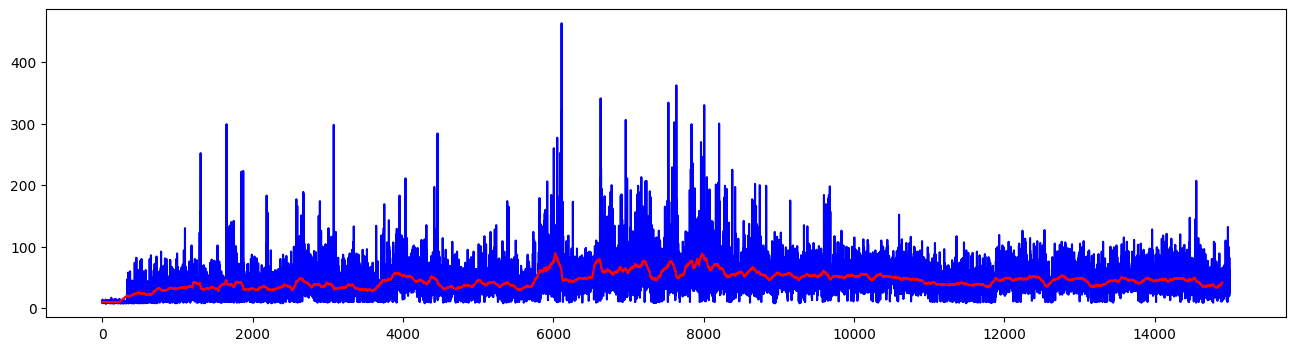

In [ ]:
# Plot the results from a training run
plt.figure(figsize=(16, 4))
plt.plot(episode_reward,"b")
y_av = running_mean(episode_reward, N=100)
plt.plot(y_av,"r")

Den röda linjen i grafen är löpande medelvärdet från episod 100 till i-100 steg, så trots att agenten får några episoder med över 200(blåa linjen) rewards per episod så är de flesta relativt dåliga. Resultaten ser dock ut att bli stabilare efter ca 10000 episoder. Genom att köra om koden flera gånger ser jag att resultatet skiljer sig mycket och att det är instabila resultat.

In [ ]:
# A set of parameters that is working well
EPISODES       = 25000  # Number of eposides to run, org. val was only 1000, but that is way too little
EPSILON        = 1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 12     # discretization steps per state variable (aviod odd numbers), org val = 10

average_cumulative_reward = 0.0

episode_reward = np.zeros(EPISODES)


# Q-table for the discretized states, and two actions
num_states = DISCRETE_STEPS ** 4
qtable = [[0., 0.] for state in range(num_states)]

EPSILON_DECAY = 0.9995  # Lagt in decay på 0.05% epsilon och 0.05% learning rate för att testa om det kan förbättra modellen genom att stegvis sänka dem för varje iteration
LEARNING_RATE_DECAY = 0.9995


for i in range(EPISODES):
    state4D = env.reset()
    state = make_state(state4D)

    terminate = False
    cumulative_reward = 0.0

    # Loop over time-steps
    while not terminate:
        # Compute what the greedy action for the current state is
        qvalues = qtable[state]
        greedy_action = argmax(qvalues)

        # Sometimes, the agent takes a random action, to explore the environment
        if random.random() < EPSILON:
            action = random.randrange(2)
        else:
            action = greedy_action

        # Perform the action
        next_state, reward, terminate, *_ = env.step(action)  # truncated & info is ignored
        next_state = make_state(next_state)

        # Update the Q-Table
        td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
        qtable[state][action] += LEARNING_RATE * td_error
        # Update statistics
        cumulative_reward += reward
        state = next_state

    # Decay för epsilon och learning rate
    EPSILON *= EPSILON_DECAY
    LEARNING_RATE *= LEARNING_RATE_DECAY
    if LEARNING_RATE< 0.01:
      LEARNING_RATE = 0.01 # För att lärningstakten inte ska bli för låg

    # store reward for every episode
    episode_reward[i] = cumulative_reward

    # Adapt epsilon and learning rate here

    # Per-episode statistics
    if ((i % 500)==0):
      print(i, cumulative_reward, sep=',')

0,31.0
500,62.0
1000,19.0
1500,58.0
2000,27.0
2500,48.0
3000,140.0
3500,164.0
4000,182.0
4500,219.0
5000,277.0
5500,241.0
6000,239.0
6500,207.0
7000,198.0
7500,180.0
8000,231.0
8500,407.0
9000,198.0
9500,151.0
10000,120.0
10500,418.0
11000,292.0
11500,410.0
12000,323.0
12500,408.0
13000,129.0
13500,390.0
14000,453.0
14500,295.0
15000,447.0
15500,509.0
16000,219.0
16500,318.0
17000,720.0
17500,395.0
18000,500.0
18500,451.0
19000,304.0
19500,311.0
20000,336.0
20500,375.0
21000,299.0
21500,318.0
22000,625.0
22500,324.0
23000,517.0
23500,378.0
24000,342.0
24500,300.0


Genom att ha en decay på både epsilon och learning rate så tillåts agenten i början göra väldigt många slumpmässiga steg med hög learning rate för att stegvis jobba sig ner mot mindre slumpmässighet och en låg inlärningstakt.
Fler episoder är inlagda och ändrat steps från 10 till 12.

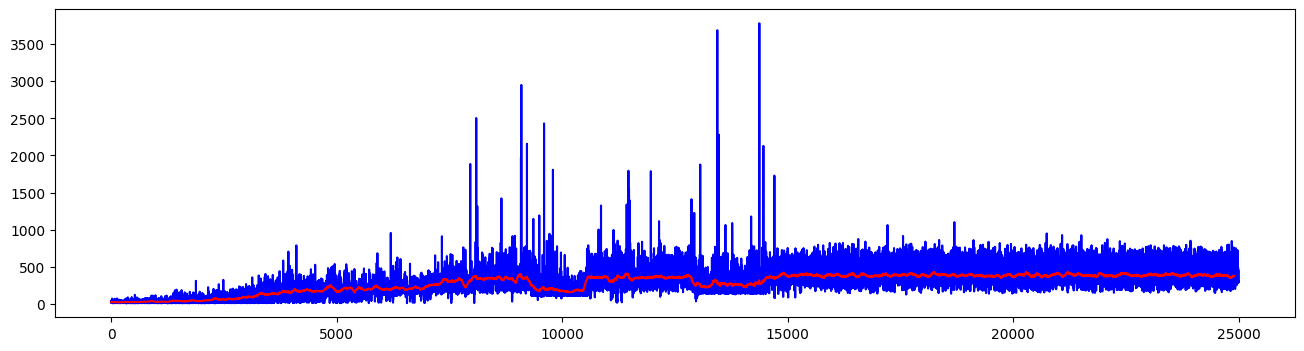

In [ ]:
# Plot the results from a training run
plt.figure(figsize=(16, 4))
plt.plot(episode_reward,"b")
y_av = running_mean(episode_reward, N=100)
plt.plot(y_av,"r")

Nu syns det att modellen sakta förbättras då antalet rewards per episod ökar stegvis och blir stabil runt episode 15 000, det är svårt att se exakta Y-värdet då pga vissa extremt höga rewards på tidigare episoder.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


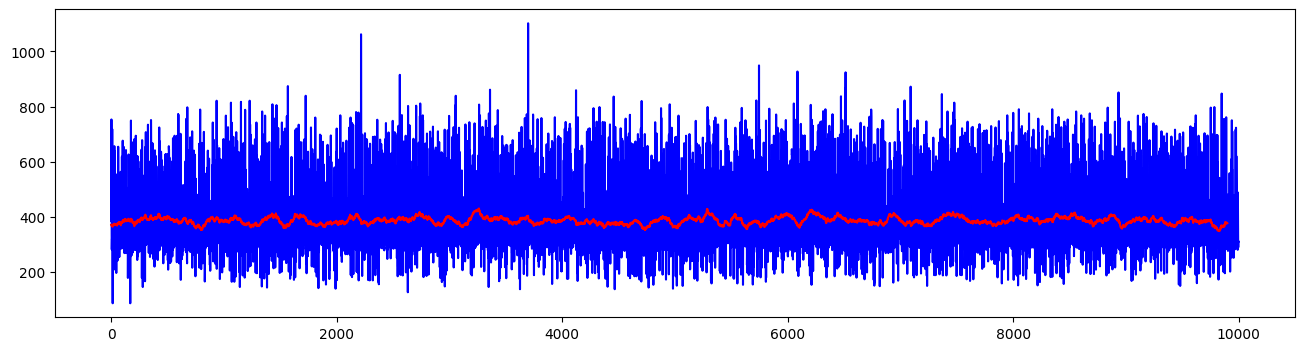

In [ ]:
# Plot the results from a training run
plt.figure(figsize=(16, 4))
plt.plot(episode_reward[15000:],"b")
y_av = running_mean(episode_reward[15000:], N=100)
plt.plot(y_av,"r")

Genom att studera rewards för episoderna där resultaten såg stabila ut så ser vi att löpande medelvärdet rör sig runt 400 rewards per episod och det får anses som ett väldifgt bra resultat.

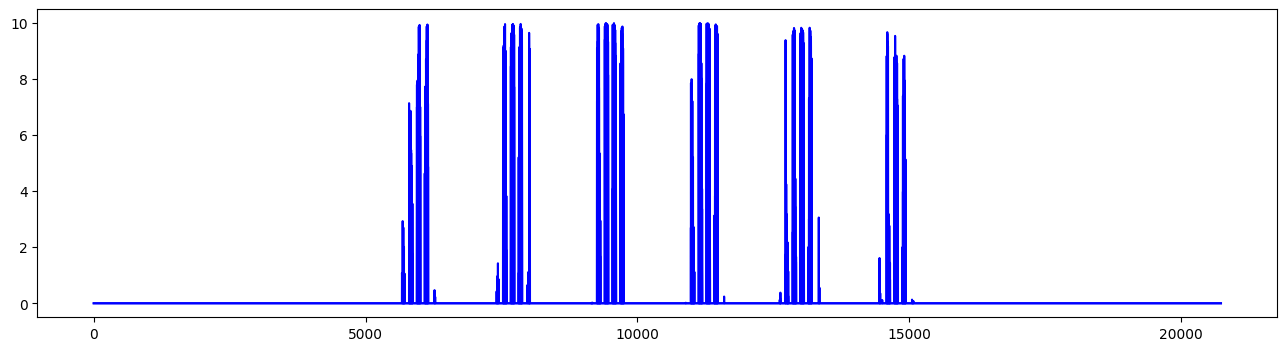

In [ ]:
# Plottar min qtable
plt.figure(figsize=(16, 4))
plt.plot(qtable,"b")


När den fyrdiminsionella rummet projiceras till ett plan syns det att en stor del av alla states inte har någon reward. Efter 5000 states syns det att agenten har och lärt sig lite av vad som ger högre rewards för de statsen. Endast steg nära mitten är det som gett agenten en reward, då states under 5000 och över 15 000 alltid har 0 som q-värde. Detta kan ha att göra med att agenten inte utforskat den delen av sökrymden.

Agenten har ändå relativt många states som ger rewards vilket gör att jag lyckats få ett okej resultat då den lärt sig hur den ska flytta pinnen när den är nära mitten. Att det fortfarande är rätt många states runt mitten som inte har en reward kan ha att göra med slumpmässigheten i Q-learning